In [1]:
!conda activate .conda

In [2]:
#!pip3 install numpy pandas matplotlib scikit-learn
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

# Cell 1: Import necessary libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter


In [4]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# Cell 2: Prepare the dataset

In [5]:
# Load dataset
df = pd.read_csv('Training/MultiLanguageTrainDataset.csv')
assert 'text' in df.columns and 'label' in df.columns, "Dataset must have 'text' and 'label' columns."

# Clean labels: remove NaN or Inf values
df = df.dropna(subset=['label'])
df = df[np.isfinite(df['label'])]

# Convert labels to float32
df['label'] = df['label'].astype('float32')

# Print label stats
print("Label Stats After Cleaning:")
print(df['label'].describe())
print(f"NaNs: {df['label'].isna().sum()}")
print(f"Infs: {(df['label'] == np.inf).sum()}")

# Simple tokenizer
def tokenize(text):
    text = text.lower()  # Make all text lowercase
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove non-alphanumeric characters
    return text.split()

# Data augmentation placeholder (you may enhance this in the future)
def synonym_replacement(tokens, prob=0.1):
    return [token if random.random() > prob else "<UNK>" for token in tokens]  # Replace with <UNK> with some probability

tokenized_texts = [tokenize(text) for text in df['text']]  # Tokenize each text
augmented_texts = [synonym_replacement(tokens) for tokens in tokenized_texts]  # Augment the data

tokenized_texts += augmented_texts  # Add augmented texts to the tokenized texts
labels = df['label'].tolist()  # Original labels
labels += labels  # Duplicate labels to match the augmented texts

# Enforce labels to be valid floats
labels = [0.0 if (np.isnan(lbl) or np.isinf(lbl)) else lbl for lbl in labels]  # Clean labels

# Build vocab
all_tokens = [token for sublist in tokenized_texts for token in sublist]  # Flatten tokenized texts
vocab = {word: idx+1 for idx, (word, _) in enumerate(Counter(all_tokens).most_common())}  # Create vocabulary
vocab["<PAD>"] = 0  # Add a padding token

import pickle

# Save vocab to a file for later use in inference
with open("vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

print("✅ Saved vocab to vocab.pkl")

# Find max token id
max_token_id = max([
    max([vocab.get(token, vocab["<PAD>"]) for token in tokens]) if tokens else vocab["<PAD>"]
    for tokens in tokenized_texts
])
print(f"Vocab size: {len(vocab)}")
print(f"Max token id: {max_token_id}")

# Encode texts
def encode(tokens, vocab, max_len):
    tokens = tokens[:max_len]  # Limit token length
    ids = [vocab.get(token, vocab["<PAD>"]) for token in tokens]  # Convert tokens to their respective ids
    ids += [vocab["<PAD>"]] * (max_len - len(ids))  # Pad the sequence to the max length
    return ids

max_len = 100  # Max sequence length
encoded_texts = [encode(tokens, vocab, max_len) for tokens in tokenized_texts]  # Encode all texts

# Train-test split (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(encoded_texts, labels, test_size=0.2, random_state=42)

# Custom dataset class for DataLoader
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Ensure labels are valid
        if torch.isnan(self.labels[idx]) or torch.isinf(self.labels[idx]):
            print(f"Invalid label at index {idx}: {self.labels[idx]}")
            return None
        return self.texts[idx], self.labels[idx]

# Custom collate function to handle empty batches
def custom_collate(batch):
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(batch)

# Create DataLoader for training and validation sets
train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)

train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    collate_fn=custom_collate,
    num_workers=0,  # Use 0 workers initially for debugging
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=256,
    shuffle=False,
    collate_fn=custom_collate,
    num_workers=0,
    pin_memory=True
)


Label Stats After Cleaning:
count    229981.000000
mean          0.388263
std           0.487897
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: label, dtype: float64
NaNs: 0
Infs: 0
✅ Saved vocab to vocab.pkl
Vocab size: 347572
Max token id: 347571


In [6]:
!pip install torchsummary

# Cell 3: Model Architecture

In [7]:
import torch
import torch.nn as nn
from torchsummary import summary

# Number of input features (now set to embedding dimension)
input_dim = 1  # This will be replaced by embedding dimension in the actual model
embedding_dim = 300  # Set embedding dimension to 300 (a standard value)
vocab_size = len(vocab)  # Vocabulary size from previous cell
num_classes = 1  # Binary classification
dropout_rate = 0.8  # Adjusted dropout rate for better learning

# Define the SelfAttention class as before
class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(SelfAttention, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        attn_weights = torch.softmax(self.attention(x), dim=1)
        weighted = x * attn_weights
        return weighted.sum(dim=1)

# Modify the TextCNN model to include an embedding layer
class TextCNN(nn.Module):
    def __init__(self, vocab_size, input_dim, num_classes, embedding_dim=300, dropout_rate=0.8):
        super(TextCNN, self).__init__()

        # Embedding layer added to convert word indices to dense vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv1d(embedding_dim, 200, kernel_size=3, padding=1),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(embedding_dim, 200, kernel_size=4, padding=2),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(embedding_dim, 200, kernel_size=5, padding=2),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1)
        )

        # Self-Attention Layer
        self.attention = SelfAttention(600)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)

        # Final fully connected layer for classification
        self.fc = nn.Linear(600, num_classes)

    def forward(self, x):
        # Ensure input x is a LongTensor for the embedding layer
        x = x.long()  # Convert to LongTensor (required by Embedding Layer)

        # Apply embedding layer to convert word indices into dense vectors
        x = self.embedding(x)  # Shape [batch_size, seq_len, embedding_dim]
        x = x.permute(0, 2, 1)  # Change shape to [batch_size, embedding_dim, seq_len] for Conv1d

        # Apply convolution layers
        x1 = self.conv1(x).squeeze(2)
        x2 = self.conv2(x).squeeze(2)
        x3 = self.conv3(x).squeeze(2)

        # Concatenate convolution outputs
        x = torch.cat((x1, x2, x3), dim=1)  # Shape [batch_size, 600]

        # Apply self-attention
        x = self.attention(x.unsqueeze(1))  # Shape [batch_size, 600]
        x = self.dropout(x)  # Apply dropout
        x = self.fc(x)  # Final output layer
        return x

# Initialize the model
model = TextCNN(vocab_size, input_dim, num_classes, embedding_dim=embedding_dim, dropout_rate=dropout_rate).to(device)

# Define the optimizer, loss function, and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-5)  # Using AdamW for better regularization
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss
scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer, base_lr=0.0005, max_lr=0.01, mode="triangular", cycle_momentum=False
)

print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")

# Print the model summary
max_seq_len = 100  # Example sequence length (replace this with your actual sequence length)
summary(model, input_size=(max_seq_len,))  # For the TextCNN model, input is of shape [batch_size, seq_len]


Learning rate: 0.000500
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1             [-1, 100, 300]     104,271,600
            Conv1d-2             [-1, 200, 100]         180,200
       BatchNorm1d-3             [-1, 200, 100]             400
              ReLU-4             [-1, 200, 100]               0
 AdaptiveMaxPool1d-5               [-1, 200, 1]               0
            Conv1d-6             [-1, 200, 101]         240,200
       BatchNorm1d-7             [-1, 200, 101]             400
              ReLU-8             [-1, 200, 101]               0
 AdaptiveMaxPool1d-9               [-1, 200, 1]               0
           Conv1d-10             [-1, 200, 100]         300,200
      BatchNorm1d-11             [-1, 200, 100]             400
             ReLU-12             [-1, 200, 100]               0
AdaptiveMaxPool1d-13               [-1, 200, 1]               0
           Line

# Cell 4: Training and Validation Loop

Epoch 1/20 - Train Loss: 0.6413 | Train Acc: 64.31% | Train F1: 0.40 | Train Precision: 0.57 | Train Recall: 0.31
Val Loss: 0.5886 | Val Acc: 68.89% | Val F1: 0.39 | Val Precision: 0.82 | Val Recall: 0.26
Epoch 2/20 - Train Loss: 0.5620 | Train Acc: 72.94% | Train F1: 0.59 | Train Precision: 0.71 | Train Recall: 0.51
Val Loss: 0.5128 | Val Acc: 77.32% | Val F1: 0.66 | Val Precision: 0.79 | Val Recall: 0.57
Epoch 3/20 - Train Loss: 0.4933 | Train Acc: 79.34% | Train F1: 0.70 | Train Precision: 0.80 | Train Recall: 0.62
Val Loss: 0.4712 | Val Acc: 81.08% | Val F1: 0.73 | Val Precision: 0.82 | Val Recall: 0.66
Epoch 4/20 - Train Loss: 0.4418 | Train Acc: 83.71% | Train F1: 0.77 | Train Precision: 0.86 | Train Recall: 0.69
Val Loss: 0.4422 | Val Acc: 83.30% | Val F1: 0.76 | Val Precision: 0.85 | Val Recall: 0.70
Epoch 5/20 - Train Loss: 0.4022 | Train Acc: 86.75% | Train F1: 0.81 | Train Precision: 0.90 | Train Recall: 0.74
Val Loss: 0.4235 | Val Acc: 84.89% | Val F1: 0.79 | Val Precision:

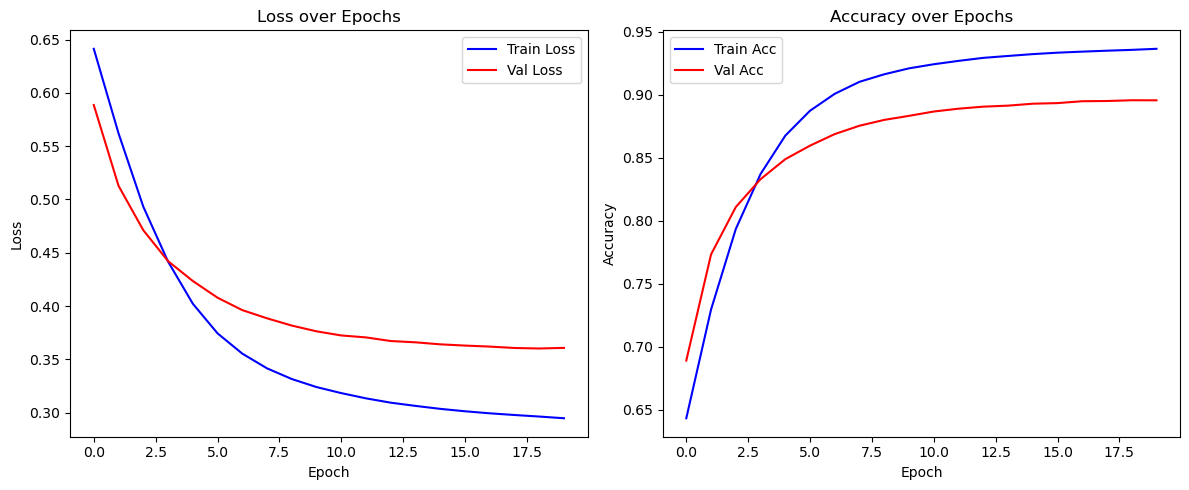

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.0, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.mode = mode

    def __call__(self, val_loss, val_acc):
        if self.best_score is None:
            self.best_score = val_loss if self.mode == 'min' else val_acc
        elif (self.mode == 'min' and val_loss < self.best_score - self.min_delta) or \
             (self.mode == 'max' and val_acc > self.best_score + self.min_delta):
            self.best_score = val_loss if self.mode == 'min' else val_acc
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Label Smoothing
def smooth_labels(labels, smoothing=0.1):
    return labels * (1 - smoothing) + 0.5 * smoothing  # Stronger smoothing

# Initialize lists to store loss and accuracy values
num_epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Early stopping instance
early_stopping = EarlyStopping(patience=7, min_delta=0.0, mode='min')  # Using 'min' for loss, 'max' for accuracy

# Start training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    all_preds, all_labels = [], []

    # Training loop
    for batch in train_loader:
        if batch is None:
            continue
        texts_batch, labels_batch = batch
        texts_batch, labels_batch = texts_batch.to(device).long(), labels_batch.to(device).float()

        if torch.isnan(labels_batch).any() or torch.isinf(labels_batch).any():
            continue

        optimizer.zero_grad()
        outputs = model(texts_batch).squeeze(1)

        # Clamping outputs to avoid outliers
        outputs = torch.clamp(outputs, min=-50, max=50)

        smoothed_labels = smooth_labels(labels_batch, smoothing=0.1)  # Apply label smoothing

        loss = criterion(outputs, smoothed_labels)
        if torch.isnan(loss) or torch.isinf(loss):
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels_batch.detach().cpu().numpy())

    # Metrics for training
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    mask = ~np.isnan(all_preds) & ~np.isnan(all_labels)
    all_preds = all_preds[mask]
    all_labels = all_labels[mask]
    
    train_acc = accuracy_score(all_labels, all_preds)
    train_precision = precision_score(all_labels, all_preds)
    train_recall = recall_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds)
    
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(train_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]*100:.2f}% | Train F1: {train_f1:.2f} | Train Precision: {train_precision:.2f} | Train Recall: {train_recall:.2f}")

    # Validation loop
    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            if batch is None:
                continue
            texts_batch, labels_batch = batch
            texts_batch, labels_batch = texts_batch.to(device).long(), labels_batch.to(device).float()

            outputs = model(texts_batch).squeeze(1)
            outputs = torch.clamp(outputs, min=-50, max=50)

            smoothed_labels = smooth_labels(labels_batch, smoothing=0.1)  # Apply label smoothing

            loss = criterion(outputs, smoothed_labels)

            val_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels_batch.detach().cpu().numpy())

    # Metrics for validation
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    mask = ~np.isnan(all_preds) & ~np.isnan(all_labels)
    all_preds = all_preds[mask]
    all_labels = all_labels[mask]

    val_acc = accuracy_score(all_labels, all_preds)
    val_precision = precision_score(all_labels, all_preds)
    val_recall = recall_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)

    print(f"Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]*100:.2f}% | Val F1: {val_f1:.2f} | Val Precision: {val_precision:.2f} | Val Recall: {val_recall:.2f}")
    
    # Scheduler and early stopping
    scheduler.step()  # Adjust the learning rate
    early_stopping(val_losses[-1], val_acc)  # Trigger early stopping if needed
    
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break

# Function to plot the graphs for Loss and Accuracy
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Val Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc', color='blue')
    plt.plot(val_accuracies, label='Val Acc', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the plot function at the end of training
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)


In [10]:
# Save model after training finishes
model_save_path = "final_model.pth"
torch.save({
    'epoch': epoch+1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}, model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to final_model.pth


# Cell 5: Plotting Loss and Accuracy

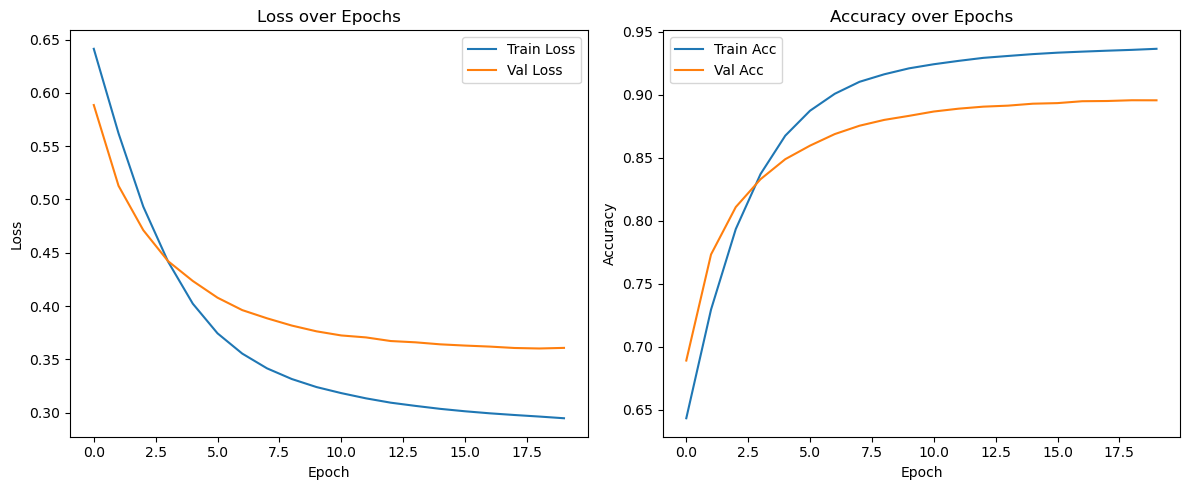

In [11]:
# Plotting Loss and Accuracy  

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Cell 6: Testing the Model on New Data

In [12]:
# Path to the testing folder
test_folder = 'Testing'

# Put the model in eval mode
model.eval()

# Loop over all CSVs in the Testing folder
for filename in os.listdir(test_folder):
    if filename.endswith('.csv'):
        filepath = os.path.join(test_folder, filename)
        print(f"Processing file: {filename}")

        # Load the CSV
        df_test = pd.read_csv(filepath)
        if 'text' not in df_test.columns or 'label' not in df_test.columns:
            print(f"Skipping {filename}: missing 'text' or 'label' column.")
            continue

        # Preprocess: tokenize and encode
        tokenized_texts = [tokenize(text) for text in df_test['text']]
        encoded_texts = [encode(tokens, vocab, max_len) for tokens in tokenized_texts]

        # Convert to tensor
        texts_tensor = torch.tensor(encoded_texts, dtype=torch.long).to(device)

        # Convert labels
        labels_tensor = torch.tensor(df_test['label'].tolist(), dtype=torch.float32).to(device)

        # Predict in batches if needed (optional)
        with torch.no_grad():
            outputs = model(texts_tensor).squeeze(1)
            predictions = torch.round(torch.sigmoid(outputs)).detach().cpu().numpy()
            actuals = labels_tensor.cpu().numpy()

        # Calculate accuracy
        accuracy = accuracy_score(actuals, predictions)
        print(f"Accuracy for {filename}: {accuracy*100:.2f}%")
        print('-' * 50)


Processing file: Chinese_test.csv
Accuracy for Chinese_test.csv: 65.22%
--------------------------------------------------
Processing file: English_test.csv
Accuracy for English_test.csv: 89.55%
--------------------------------------------------
Processing file: Filipino_test.csv
Accuracy for Filipino_test.csv: 70.34%
--------------------------------------------------
Processing file: French_test.csv
Accuracy for French_test.csv: 82.50%
--------------------------------------------------
Processing file: German_test.csv
Accuracy for German_test.csv: 59.29%
--------------------------------------------------
Processing file: Indonesian_test.csv
Accuracy for Indonesian_test.csv: 86.03%
--------------------------------------------------
Processing file: Italian_test.csv
Accuracy for Italian_test.csv: 73.44%
--------------------------------------------------
Processing file: Korean_test.csv
Accuracy for Korean_test.csv: 45.57%
--------------------------------------------------
Processing fil

# Cell 7: Load Model and Predict from User Input

In [14]:
# Load the model from saved checkpoint
model_load_path = "final_model.pth"

try:
    checkpoint = torch.load(model_load_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    print(f"Model loaded successfully from {model_load_path}")
except Exception as e:
    print(f"Error loading the model: {e}")

# Tokenization function
def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text.split()

# Encoding function
def encode(tokens, vocab, max_len):
    ids = [vocab.get(token, vocab["<PAD>"]) for token in tokens[:max_len]]
    ids += [vocab["<PAD>"]] * (max_len - len(ids))
    return ids

max_len = 100  # Must match training

# User input loop
while True:
    user_input = input("\nEnter text to classify (or type 'exit' to quit): ")
    if user_input.strip().lower() == 'exit':
        print("Exiting.")
        break
    
    tokens = tokenize(user_input)
    encoded_input = encode(tokens, vocab, max_len)
    input_tensor = torch.tensor([encoded_input], dtype=torch.long).to(device)
    
    with torch.no_grad():
        output = model(input_tensor).squeeze(1)
        prob = torch.sigmoid(output).item()
        prediction = 1 if prob >= 0.5 else 0
        print(f"Predicted Label: {prediction} (Probability: {prob:.4f})")


Model loaded successfully from final_model.pth
Predicted Label: 1 (Probability: 0.7967)
Predicted Label: 1 (Probability: 0.5417)
Predicted Label: 0 (Probability: 0.2541)
Predicted Label: 0 (Probability: 0.4460)
Predicted Label: 0 (Probability: 0.2477)
Predicted Label: 1 (Probability: 0.5975)
Predicted Label: 1 (Probability: 0.7790)
Exiting.
